In [4]:
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from scipy.fftpack import fft
from scipy.ndimage.filters import gaussian_filter

from sklearn.metrics import f1_score

plt.style.use('seaborn')

### Import Data

In [5]:
from utils import data

In [6]:
x_train, y_train = data.load_training_data()

In [7]:
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of y_train: {y_train.shape}')

Shape of x_train: (45360, 512, 3)
Shape of y_train: (45360,)


### Preprocessing

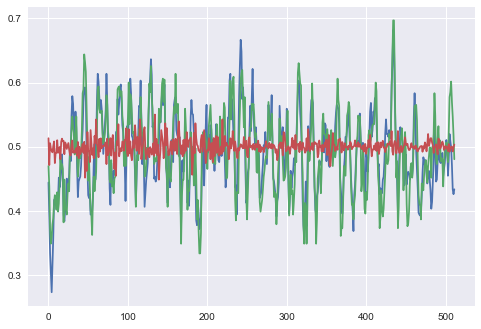

In [94]:
# Plot example
plt.plot(x_train[0])
plt.show()

In [101]:
# Fourier transform data
x_train_fft = np.abs(fft(x_train, n=len(x_train[0]), axis=1))
x_train_fft = x_train_fft[:, :1 + int((len(x_train_fft[0]) - 1) / 2)]

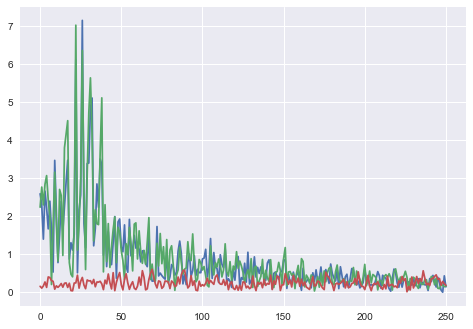

In [166]:
plt.plot(x_train_fft[0, 5:])
plt.show()

In [167]:
# Apply Gaussian filter
# Not used in training, worsens performance
x_train_gauss = x_train_fft.copy()

for i in range(x_train.shape[-1]):
    x_train_gauss[:, :, i] = gaussian_filter(x_train_fft[:, :, i], sigma=2)

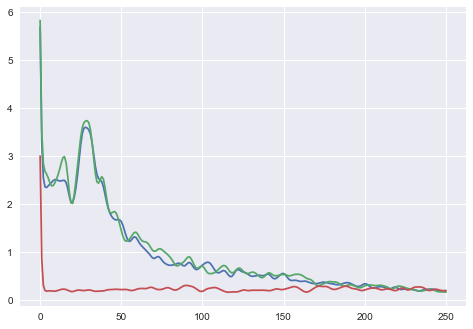

In [168]:
plt.plot(x_train_gauss[0, 5:])
plt.show()

In [271]:
# Add channel dimension for CNN
x_train_cnn = np.expand_dims(x_train_fft, axis=3)
print(f'Shape of x_train_cnn: {x_train_cnn.shape}')

Shape of x_train_cnn: (45360, 256, 3, 1)


### Build CNN models

In [42]:
# Generate weights for training (imbalanced classes)
class_weight = {}

count_0, count_1, count_2 = np.bincount(y_train)
total = count_0 + count_1 + count_2

for i in range(3):
    class_weight[i] = (1 / [count_0, count_1, count_2][i]) * total

In [265]:
# 1D CNN
model_cnn = keras.Sequential([
    keras.layers.Conv1D(filters=16, input_shape=(x_train_fft.shape[1], x_train_fft.shape[2]), kernel_size=(8), 
                        activation='tanh', kernel_regularizer='l2', padding='same'),
    keras.layers.AveragePooling1D(pool_size=2, strides=1),
    keras.layers.Conv1D(filters=16, kernel_size=(4), 
                        activation='tanh', kernel_regularizer='l2', padding='same'),
    keras.layers.AveragePooling1D(pool_size=2, strides=1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='elu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3, activation='softmax')
])

model_cnn.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [284]:
# 2D CNN (not very tuned)
model_cnn_2 = keras.Sequential([
    # Temporal convolution
    keras.layers.Conv2D(filters=16, kernel_size=(16, 1), padding='same', 
                        input_shape=(x_train_fft.shape[1], x_train_fft.shape[2], 1)),
    keras.layers.AveragePooling2D(pool_size=(4, 1)),
    # Temporal and channel convolution
    keras.layers.Conv2D(filters=16, kernel_size=(8, 3), padding='same'),
    keras.layers.AveragePooling2D(pool_size=(2, 3)),
    # Channel convolution
    keras.layers.Conv2D(filters=8, kernel_size=(1, 3), padding='same'),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='elu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3, activation='softmax')
])

model_cnn_2.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [266]:
history_cnn = model_cnn.fit(x_train_fft, y_train, epochs=10, class_weight=class_weight, 
                            shuffle=True)

Epoch 1/10
45360/45360 [==============================] - 20s 452us/sample - loss: 0.8857 - acc: 0.9256
Epoch 2/10
45360/45360 [==============================] - 18s 403us/sample - loss: 0.6617 - acc: 0.9407
Epoch 3/10
45360/45360 [==============================] - 18s 396us/sample - loss: 0.5770 - acc: 0.9447
Epoch 4/10
45360/45360 [==============================] - 18s 406us/sample - loss: 0.5202 - acc: 0.9493
Epoch 5/10
45360/45360 [==============================] - 18s 398us/sample - loss: 0.5023 - acc: 0.9493
Epoch 6/10
45360/45360 [==============================] - 18s 396us/sample - loss: 0.4907 - acc: 0.9500
Epoch 7/10
45360/45360 [==============================] - 20s 448us/sample - loss: 0.4697 - acc: 0.9521
Epoch 8/10
45360/45360 [==============================] - 20s 433us/sample - loss: 0.4666 - acc: 0.9506
Epoch 9/10
45360/45360 [==============================] - 19s 428us/sample - loss: 0.4477 - acc: 0.9528
Epoch 10/10
45360/45360 [==============================] - 19s 4

In [283]:
train_f1_1d = f1_score(y_train, np.argmax(model_cnn.predict(x_train_fft), axis=1), average='macro')
print(f'1D F1 score on training data: {train_f1_1d:.4f}')

1D F1 score on training data: 0.9273


In [285]:
history_cnn_2 = model_cnn_2.fit(x_train_cnn, y_train, epochs=5, class_weight=class_weight, 
                            shuffle=True)

Epoch 1/5
45360/45360 [==============================] - 51s 1ms/sample - loss: 0.6938 - acc: 0.9232
Epoch 2/5
45360/45360 [==============================] - 60s 1ms/sample - loss: 0.5398 - acc: 0.9410
Epoch 3/5
45360/45360 [==============================] - 51s 1ms/sample - loss: 0.5163 - acc: 0.9438
Epoch 4/5
45360/45360 [==============================] - 52s 1ms/sample - loss: 0.5008 - acc: 0.9456
Epoch 5/5
45360/45360 [==============================] - 45s 981us/sample - loss: 0.4944 - acc: 0.9457


In [282]:
train_f1_2d = f1_score(y_train, np.argmax(model_cnn_2.predict(x_train_cnn), axis=1), average='macro')
print(f'2D F1 score on training data: {train_f1_2d:.4f}')

2D F1 score on training data: 0.9224


The performance of the convolutional models is quite similar, and does not change substantially with a change of the model structure. It is likely that this is overkill for the problem and the most relevant information is already given by the rough shape of the Fourier transform, without the need for more complex convolutional filters.

### Evaluate on Test Data

In [145]:
x_test = data.load_testing_data()

In [146]:
# Fourier transform data

x_test_fft = np.abs(fft(x_test, n=len(x_test[0]), axis=1))
x_test_fft = x_test_fft[:, :1 + int((len(x_test_fft[0]) - 1) / 2)]

In [172]:
# Get prediction & generate submission file
y_test_pred = model_cnn.predict(x_test_fft)
data.generate_submission(y_test_pred, 'CNN_Pred')